# Modelo de Amarre Fuerte

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json

In [4]:
%matplotlib notebook

In [5]:
def Ejes (A, B, C, AB, BC, AC):
    '''
    Genera un Array de tres vectores X, Y, Z con módulo A, B, C y 
    ángulos entre ellos AB, BC, AC (en radianes).
    Fija la libertad de variables tomando X=(A1,0,0) y Y=(B1,B2,0)
    (Las expresiones salen de resolver las ecuaciones de producto punto entre los 3 vectores)
    '''
    p, q, r = np.around(A*B*np.cos(AB),4), np.around(B*C*np.cos(BC),4), np.around(A*C*np.cos(AC),4)
    X = np.array([A,0,0])
    Y = np.array([p/A, np.sqrt(B**2-p**2/A**2),0])
    Z = np.array([r/A, (q-p*r/A**2)/Y[1], np.sqrt(C**2-((q-p*r/A**2)/Y[1])**2-(r/A)**2)])
    return np.array([X,Y,Z])

In [6]:
class Red(object):
    """Clase que representa una red (retícula)
    
    Esencialmente, es un arreglo de tres vectores. Se asume que las unidades son Angstrom.
    
    """
    
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, a1, a2, a3):
        """
        Crear una red a partir de tres vectores. Se asume que las unidades son Angstrom.
        
        Argumentos:
          a1, a2, a3 -> vectores (arreglos de numpy)
        """
        m = np.array([a1,a2,a3], dtype=np.float64).reshape((3, 3))
        lengths = np.sqrt(np.sum(m ** 2, axis=1))
        angles = np.zeros(3)
        for i in range(3):
            j = (i + 1) % 3
            k = (i + 2) % 3
            angles[i] = np.dot(m[j], m[k]) / (lengths[j] * lengths[k])
            
        # Los siguientes son atributos de la clase.
        # De forma convencional, el guión bajo se usa cuando no se espera que el usuario use estos atributos
        self._angles = np.arccos(angles) * 180. / np.pi
        self._lengths = lengths
        self._matrix = m
        self._a1 = np.array(a1)
        self._a2 = np.array(a2)
        self._a3 = np.array(a3)
        
    # Luego se pueden implementar propiedades 
    
    @property
    def angles(self):
        """
        Ángulos (alpha, beta, gamma) de la red.
        """
        return tuple(self._angles)

    @property
    def a(self):
        """
        Parámetro de red a
        """
        return self._lengths[0]

    @property
    def b(self):
        """
        Parámetro de red b
        """
        return self._lengths[1]

    @property
    def c(self):
        """
        Parámetro de red c
        """
        return self._lengths[2]

    @property
    def abc(self):
        """
        Longitudes de los vectores de red, i.e. (a, b, c)
        """
        return tuple(self._lengths)
        
    # También se pueden implementar métodos.
    
    def plot (self,ax):
        """
        Incluye los vectores de red en el gráfico ax
        
        Argumentos:
            ax -> un eje con proyección 3d
        """
        Axes3D.plot3D(ax,[0,self._a1[0]],[0,self._a1[1]],[0,self._a1[2]],'k')
        Axes3D.plot3D(ax,[0,self._a2[0]],[0,self._a2[1]],[0,self._a2[2]],'k')
        Axes3D.plot3D(ax,[0,self._a3[0]],[0,self._a3[1]],[0,self._a3[2]],'k')
        Axes3D.grid(ax,False)
        
    def get_supercell(self, repetitions, with_plot=False, ax=None,centered =False):
        """
        Construye supercelda según la lista de enteros en repetitions
        """
        repx = repetitions[0]
        repy = repetitions[1]
        repz = repetitions[2]
        if centered:
            pts = np.zeros([(2*repx+1)*(2*repy+1)*(2*repz+1),3])
            ctr = 0
            for ix in range(-repx, repx+1):
                for iy in range(-repy, repy+1):
                    for iz in range(-repz, repz+1):
                        pts[ctr,:]= ix*self._a1+iy*self._a2 +iz*self._a3 
                        ctr+=1
        else:
            pts = np.zeros([(repx+1)*(repy+1)*(repz+1),3])
            ctr = 0
            for ix in range(repx+1):
                for iy in range(repy+1):
                    for iz in range(repz+1):
                        pts[ctr,:]= ix*self._a1+iy*self._a2 +iz*self._a3 
                        ctr+=1
        
        if with_plot:
            self.plot_supercell(ax,pts)
        
        return pts
        
    def plot_supercell (self,ax, pts):
        """
        Incluye los vectores de red en el gráfico ax
        
        Argumentos:
            ax -> un eje con proyección 3d
        """
        npts=np.shape(pts)[0]
        for i in range(npts):
            ax.scatter(pts[i,0],pts[i,1],pts[i,2], c='0.55', s=20)
            
        
        
        
    def get_wigner_seitz (self, plot=False, ax=None):
        """
        Construye la celda de Wigner Seitz
        
        Regresa los vértices
        """
        #forma sencilla (usando hint de Raúl)
        from scipy.spatial import Voronoi, voronoi_plot_2d

        pts = self.get_supercell([1,1,1], centered = True)
        
        v = Voronoi(pts)
        idx = -1
        for i in range(len(v.regions)):
            try:
                if v.regions[i][0] >= 0 :
                    idx = i
            except:
                print ('no elements')
        
        if idx < 0 :
            print ('No se pudo encontrar la celda de WS')
        else:
            ver = v.vertices[v.regions[idx]]
        
        if plot:
            max_length=1.1*np.max(self.abc)
            nats = len(ver)
            coords = ver
            d0 = []
            for iat in range(nats):
                for jat in range(iat,nats):
                    dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                    if dist > 0:
                        d0.append(dist)
            d0 =np.array(d0)
            
            max_length = 1.1*np.min(d0)
            
            for iat in range(nats):
                for jat in range(iat,nats):
                    dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                    if (dist <= max_length):
                        Axes3D.plot3D(ax,[coords[iat,0],coords[jat,0]],[coords[iat,1],coords[jat,1]]
                                      ,[coords[iat,2],coords[jat,2]],'g--')
        
        return ver

In [7]:
class Base_atomica (object):
    """
    Clase que determina la base atómica de un cristal con base en una lista de coordenadas y una lista de elementos
    """
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, coords, elements, coords_relative=True):
        """
        Crear una base atómica a partir de una lista de coordenadas y de átomos 
        Se asume por ausencia que las posiciones están dadas en coordenadas relativas
        
        Argumentos:
          coords -> arreglo de coordenadas (vectores)
          elements -> lista de elementos
          coords_relative -> BOOL (True por descarte)
        """
        coor = np.array(coords, dtype=np.float64)
        
        nats = np.shape(coor)[0]
        if ( len(elements) != nats):
            print ('Error: El número de elemntos y el número de átomos (coordenadas) debe ser el mismo')
                   
        self.coords = coor
        self.elements = elements
        self.nats = nats
        self.relative = coords_relative
        
    def son_relativas(self):
        return self.relative
    
    def get_number_of_atoms(self):
        return self.nats
    
    def plot(self, ax):
        nats = self.nats
        for i in range(self.nats):
            ax.scatter(self.coords[i,0],self.coords[i,1],self.coords[i,2], c='b', s=60)
        

In [20]:
class Cristal(object):
    """
    Clase que determina un cristal con base en una red y una base atómica
    """
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self,red,base):
        """
        Crear un cristal a partir de una red y una base atómica
        
        Argumentos:
          red -> Instancia de la clase Red
          base -> Instancia de la clase Base_atomica
        """
        if type(red) != Red:
            print ('Error: debes especificar un objeto Red como entrada')
        if type(base) != Base_atomica:
            print ('Error: debes especificar un objeto Base_atomica como entrada')
        
        if base.son_relativas():
            coords = base.coords
        else:
            coords = np.zeros((base.nats,3))
            for i in range(3):
                coords[:,i] = base.coords[:,i]/red.abc[i]
        
        self.cart_coords = np.zeros((base.nats,3))
        
        for i in range(base.nats):
            self.cart_coords[i,:] = coords[i,0]*red._a1 + coords[i,1]*red._a2+coords[i,2]*red._a3
            
        self.relative = coords
        self.base = Base_atomica(coords, base.elements)
        self.red = Red (red._a1,red._a2,red._a3)
        self.reciprocal = 2*np.pi*(np.linalg.inv(red._matrix)).T
        
        with open("./periodic_table.json", "rt") as f:
            pt_data = json.load(f)
        Z = []
        for i in range(len(base.elements)):
            Z.append(pt_data[base.elements[i]]['Atomic no'])
        self.Z = Z
        
        
        
    def plot(self,ax,max_length=2.0):
        base_cart = Base_atomica(self.cart_coords, self.base.elements)
        base_cart.plot(ax)
        self.red.plot(ax)
        self.dibuja_enlaces(ax,max_length=max_length)
        
    def dibuja_enlaces(self,ax, max_length=2.0):
        #max_length=0.5*self.red.a
        nats = self.base.nats
        coords = self.cart_coords
        for iat in range(nats):
            for jat in range(iat,nats):
                dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                if (dist <= max_length):
                    Axes3D.plot3D(ax,[coords[iat,0],coords[jat,0]],[coords[iat,1],coords[jat,1]]
                                  ,[coords[iat,2],coords[jat,2]],'r')
    
    def get_supercell(self,rep,centered=False):
        pts = self.red.get_supercell(rep,centered=centered)
        cart_coords = self.cart_coords
        new_coords = []
        new_specs = []
        for i  in range(len(pts)):
            for iat in range(self.base.nats):
                new_coords.append(cart_coords[iat,:]+pts[i,:])
                new_specs.append(self.base.elements[iat])
        
        a1 = rep[0]*self.red._a1
        a2 = rep[1]*self.red._a2
        a3 = rep[2]*self.red._a3
          
        newred = Red(a1,a2,a3)
        newbase = Base_atomica(new_coords,new_specs,coords_relative=False)
        newcristal = Cristal(newred,newbase)
        return newcristal
    
    
    def get_reciprocal(self):
        return self.reciprocal
        
    def get_brillouin_zone(self, with_plot=False, ax=None):
        rec = Red(self.reciprocal[0,:],self.reciprocal[1,:],self.reciprocal[2,:])
        if with_plot:
            bz = rec.get_wigner_seitz(plot=True, ax=ax)
        else:
            bz = rec.get_wigner_seitz()
        return bz
    

    def get_atoms_WS(self, with_plot = False, ax=None):
        """
        Aquí se sigue la definición de la primera celda de Wigner Seitz que contiene
        el conjunto de puntos que están más cerca al origen que a cualquier otro punto de la red
        """
        pts = self.red.get_supercell([2,2,2], centered = True)
        cart_coords = self.cart_coords
        new_coords = []
        new_specs = []
        for i  in range(len(pts)):
            for iat in range(self.base.nats):
                new_coords.append(cart_coords[iat,:]+pts[i,:])
                new_specs.append(self.base.elements[iat])
        
        new_coords = np.array(new_coords)
        nats = np.shape(new_coords)[0]
        if with_plot:
            ver_ws = self.red.get_wigner_seitz(plot=True, ax=ax)
        else:    
            ver_ws = self.red.get_wigner_seitz()
        d0 = 0.
        for iver in range(len(ver_ws)):
            if np.linalg.norm(ver_ws[iver,:]) > d0 :
                d0 = np.linalg.norm(ver_ws[iver,:])
        #print d0
        at_ws =[]
        for iat in range(nats):
            dist = np.linalg.norm( new_coords[iat,:])
            if dist <= d0*1.2:
                #at_ws.append(neart_coords = new_coords[iat,:])
                at_ws.append(new_coords[iat,:])
                if with_plot :
                    ax.scatter(new_coords[iat,0],new_coords[iat,1],new_coords[iat,2], c='b', s=60)
        
        return at_ws
    
    def vecinos_orden_n(self, r, n, E = 0.1):
        """
        Genera una lista de listas con los primeros n-ésimos vecinos del átomo localizado en r con error numérico E.
        De manera que n_vecinos[i] te da la lista de los i-esimos vecinos (i=0 te da el mismo átomo, asumiendo que r es un punto del cristal)
        """
        S = self.get_supercell([n+1,n+1,n+1],centered=True).cart_coords #Coordenadas de los potenciales vecinos con longitud N
        d = np.linalg.norm((S-r),axis = 1)
        Ordenados = [[d[i],*S[i]] for i in np.argsort(d)] #Ordenamos todos las distancias y vectores de menor distancia a mayor
        #return Ordenados
        n_vecinos = []
        for i in range(0,n+1): #Obtiene el n-ésimo vecino
            i_vecinos = []
            d_i = Ordenados[0][0]
            while np.abs(d_i-Ordenados[0][0])<E: #Mueve el vecino de ordenados a i_vecinos mientras estemos cerca de d_i
                i_vecinos.append(Ordenados[0][1:])
                Ordenados.pop(0)
            n_vecinos.append(i_vecinos)
        return n_vecinos
        
    def vecinos(self, n, E = 0.1):
        '''
        Genera una lista de todos los vecinos de la base atómica de orden n, de manera que 
        vecinos[i][j][a] es la componente a del j-ésimo vecino del i-ésimo elemento de la base atómica
        '''
        L = []
        R = self.cart_coords
        for r in R:
            Lr = []
            a = self.vecinos_orden_n(r, n, E)[1:] #Nos quitamos el primero que es el elemento mismo
            for Vn in a:
                Lr += [v for v in Vn]
            L.append(Lr)
        return L
            
        
        

# Celda cúbica centrada en el centro

In [41]:
a0 =1.0
base = Base_atomica ([[0.5,0.5,0.5],[1,0,0]],2*['C'])
red =  Red([a0,0,0],[0,a0,0],[0,0,a0])
Cubo = Cristal(red, base)

In [42]:
a = Cubo.vecinos_orden_n([0.5,0.5,0.5],n=2,E=0.2)
a

[[[0.5, 0.5, 0.5]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [0.0, 1.0, 0.0],
  [0.0, 1.0, 1.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 1.0],
  [1.0, 1.0, 0.0],
  [1.0, 1.0, 1.0],
  [-0.5, 0.5, 0.5],
  [0.5, -0.5, 0.5],
  [0.5, 0.5, 1.5],
  [0.5, 1.5, 0.5],
  [0.5, 0.5, -0.5],
  [1.5, 0.5, 0.5]],
 [[-0.5, 0.5, -0.5],
  [0.5, -0.5, -0.5],
  [0.5, -0.5, 1.5],
  [-0.5, 0.5, 1.5],
  [1.5, 0.5, 1.5],
  [-0.5, 1.5, 0.5],
  [0.5, 1.5, -0.5],
  [1.5, 1.5, 0.5],
  [1.5, 0.5, -0.5],
  [-0.5, -0.5, 0.5],
  [0.5, 1.5, 1.5],
  [1.5, -0.5, 0.5]]]

In [43]:
b = Cubo.vecinos(2,E=0.2)
b[0]

[[0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 1.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 1.0],
 [1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0],
 [-0.5, 0.5, 0.5],
 [0.5, -0.5, 0.5],
 [0.5, 0.5, 1.5],
 [0.5, 1.5, 0.5],
 [0.5, 0.5, -0.5],
 [1.5, 0.5, 0.5],
 [-0.5, 0.5, -0.5],
 [0.5, -0.5, -0.5],
 [0.5, -0.5, 1.5],
 [-0.5, 0.5, 1.5],
 [1.5, 0.5, 1.5],
 [-0.5, 1.5, 0.5],
 [0.5, 1.5, -0.5],
 [1.5, 1.5, 0.5],
 [1.5, 0.5, -0.5],
 [-0.5, -0.5, 0.5],
 [0.5, 1.5, 1.5],
 [1.5, -0.5, 0.5]]

<IPython.core.display.Javascript object>


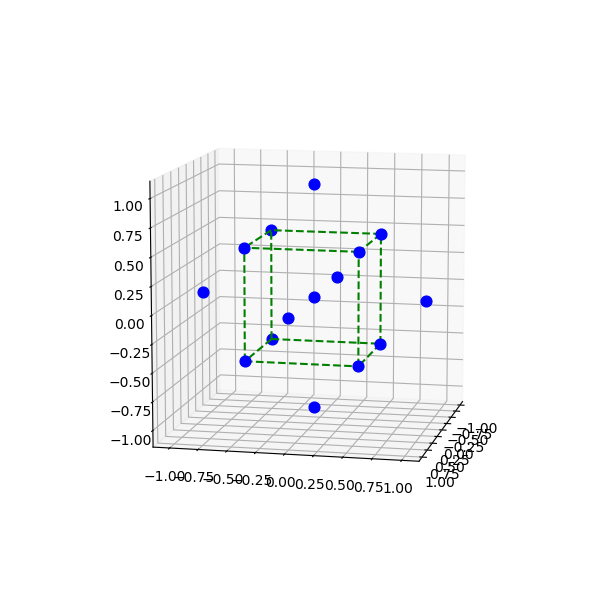

no elements


In [44]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111, projection='3d')
atoms = Cubo.get_atoms_WS(with_plot=True, ax=ax1)
ax1.view_init(elev=5., azim=0)
plt.show()
#print(atoms)

# Grafito

In [29]:
a0 = 1.0
base = Base_atomica ([[1.0/3,1.0/3,0],[2.0/3,2.0/3,0]],2*['C'])
red =  Red([np.sqrt(3)/2*a0,-a0/2.0,0],[np.sqrt(3)/2*a0,a0/2,0],[0,0,3*a0])
Grafito = Cristal(red, base)

Grafito.vecinos_orden() tiene al elemento en cuestión, los 3 primeros vecinos, y otros 5 segundos vecinos, pero deberían de ser 6.
Hay errores numéricos en la base atómica (no es un hexágono perfecto), por lo que el sexto no lo obtiene.

In [36]:
a = Grafito.vecinos_orden_n([0.5,-2.88675135e-01,0],n=2,E=0.3182)
a

[[[0.49999999999999994, -0.28867513459481287, 0.0]],
 [[0.6830127018922193, 0.10566243270259357, 0.0],
  [0.9999999999999999, -0.5773502691896257, 0.0],
  [-0.18301270189221933, -0.39433756729740643, 0.0]],
 [[0.8169872981077807, -0.9716878364870322, 0.0],
  [0.18301270189221933, 0.39433756729740643, 0.0],
  [0.1339745962155613, -1.0773502691896257, 0.0],
  [-0.36602540378443865, -0.7886751345948129, 0.0],
  [1.3660254037844386, 0.21132486540518713, 0.0]]]

In [39]:
b = Grafito.vecinos(2,E=0.3182)
b[0]

[[0.18301270189221933, 0.39433756729740643, 0.0],
 [0.9999999999999999, -0.5773502691896257, 0.0],
 [0.36602540378443865, 0.7886751345948129, 0.0],
 [1.3660254037844386, 0.21132486540518713, 0.0],
 [-0.18301270189221933, -0.39433756729740643, 0.0],
 [0.8169872981077807, -0.9716878364870322, 0.0],
 [1.049038105676658, 0.8943375672974064, 0.0],
 [-0.49999999999999994, 0.28867513459481287, 0.0],
 [1.549038105676658, 0.6056624327025936, 0.0],
 [0.1339745962155613, -1.0773502691896257, 0.0],
 [1.6830127018922192, -0.47168783648703216, 0.0],
 [-0.36602540378443865, -0.7886751345948129, 0.0],
 [-0.6830127018922193, -0.10566243270259357, 0.0],
 [1.8660254037844384, -0.07735026918962573, 0.0],
 [-0.1339745962155613, 1.0773502691896257, 0.0]]

<IPython.core.display.Javascript object>


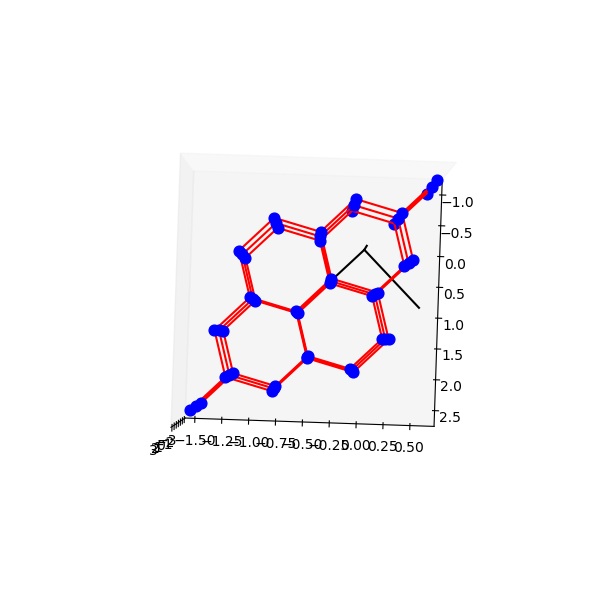

In [33]:
sc = Grafito.get_supercell([1,1,1],centered=True)
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111, projection='3d')
sc.plot(ax2,max_length=0.7)
ax2.view_init(elev=5., azim=0)
plt.show()
#print(sc.cart_coords)

# Silicio

In [21]:
ejes= Ejes(2.968,2.968,2.968,np.radians(109.471),np.radians(109.471),np.radians(109.471))

In [22]:
ejes= Ejes(3.868,3.868,3.868,np.radians(60),np.radians(60),np.radians(60))
base = Base_atomica ([[0,0,0],[0.25,0.25,0.25]],2*['Si'])
red =  Red(*ejes)
Silicio = Cristal(red, base)

In [23]:
a = Silicio.vecinos_orden_n([0,0,0],2)
a

[[[0.0, 0.0, 0.0]],
 [[-0.9809288597296458, 1.194924891863488, 0.6446675284381009]],
 [[-0.7218170971088095, -1.706078210512514, 0.6446675284381009]]]

In [35]:
b = Silicio.vecinos(2)
b[0]

[[-0.9809288597296458, 1.194924891863488, 0.6446675284381009],
 [-0.7218170971088095, -1.706078210512514, 0.6446675284381009]]

<IPython.core.display.Javascript object>


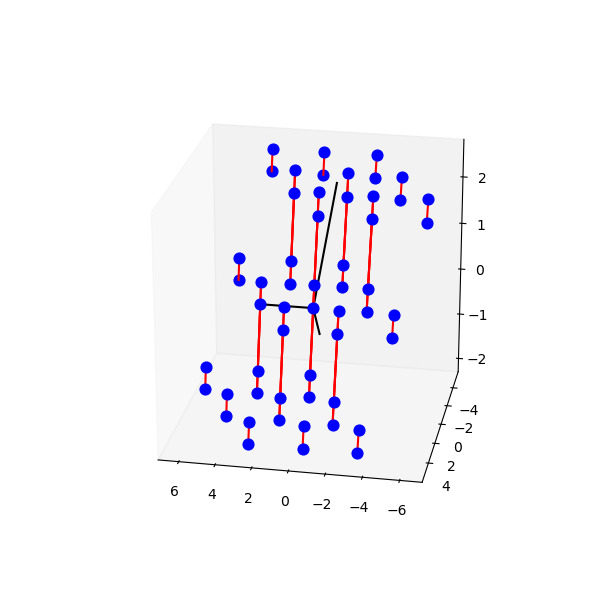

In [13]:
sc = Silicio.get_supercell([1,1,1],centered=True)
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111, projection='3d')
sc.plot(ax2,max_length=2.4)
ax2.view_init(elev=5., azim=0)
plt.show()